1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import ensemble
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold, learning_curve

# Ensemble Methods
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Загрузка датасета

In [5]:
df = pd.read_csv('churn_data.csv')

### Анализ датасета

In [6]:
# размеры датасета
print(df.shape)

(10000, 14)


In [7]:
# просмотр записей(строк) из начала датафрейма
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00000,1,1,1,101348.88000,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86000,1,0,1,112542.58000,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80000,3,1,0,113931.57000,1
3,4,15701354,Boni,699,France,Female,39,1,0.00000,2,0,0,93826.63000,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82000,1,1,1,79084.10000,0


In [8]:
# сведения о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
# описание количественных переменных
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.00000,5000.50000,2886.89568,1.00000,2500.75000,5000.50000,7500.25000,10000.00000
CustomerId,10000.00000,15690940.56940,71936.18612,15565701.00000,15628528.25000,15690738.00000,15753233.75000,15815690.00000
CreditScore,10000.00000,650.52880,96.65330,350.00000,584.00000,652.00000,718.00000,850.00000
Age,10000.00000,38.92180,10.48781,18.00000,32.00000,37.00000,44.00000,92.00000
Tenure,10000.00000,5.01280,2.89217,0.00000,3.00000,5.00000,7.00000,10.00000
Balance,10000.00000,76485.88929,62397.40520,0.00000,0.00000,97198.54000,127644.24000,250898.09000
NumOfProducts,10000.00000,1.53020,0.58165,1.00000,1.00000,1.00000,2.00000,4.00000
HasCrCard,10000.00000,0.70550,0.45584,0.00000,0.00000,1.00000,1.00000,1.00000
IsActiveMember,10000.00000,0.51510,0.49980,0.00000,0.00000,1.00000,1.00000,1.00000
EstimatedSalary,10000.00000,100090.23988,57510.49282,11.58000,51002.11000,100193.91500,149388.24750,199992.48000


In [10]:
# категориальные переменные
df.describe(include=['O']).T

,count,unique,top,freq
Surname,10000,2932,Smith,32
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


In [11]:
# проверка датасета на наличие пропусков
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [12]:
# целевая переменная
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

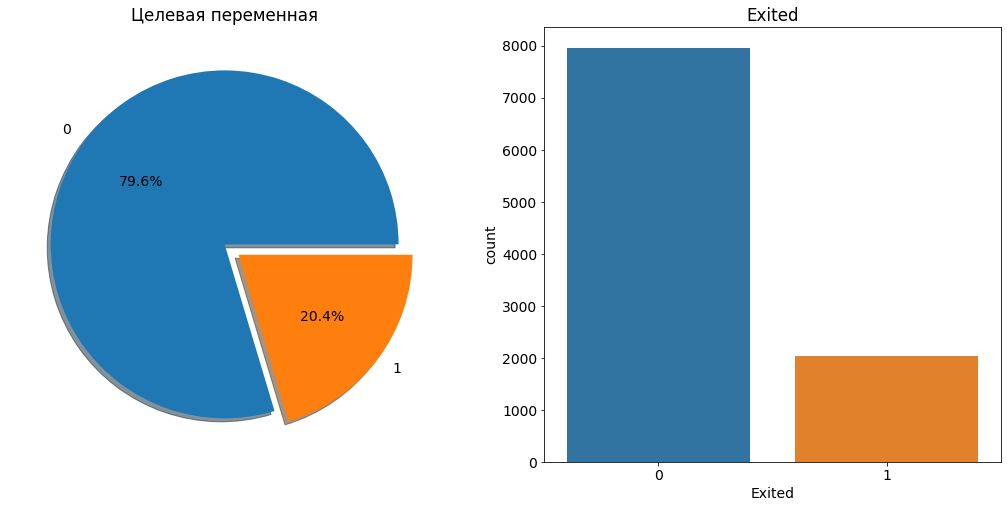

In [13]:
f, ax=plt.subplots(1, 2, figsize=(18, 8))
df['Exited'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Целевая переменная')
ax[0].set_ylabel('')
sns.countplot('Exited', data=df, ax=ax[1])
ax[1].set_title('Exited')
plt.show()

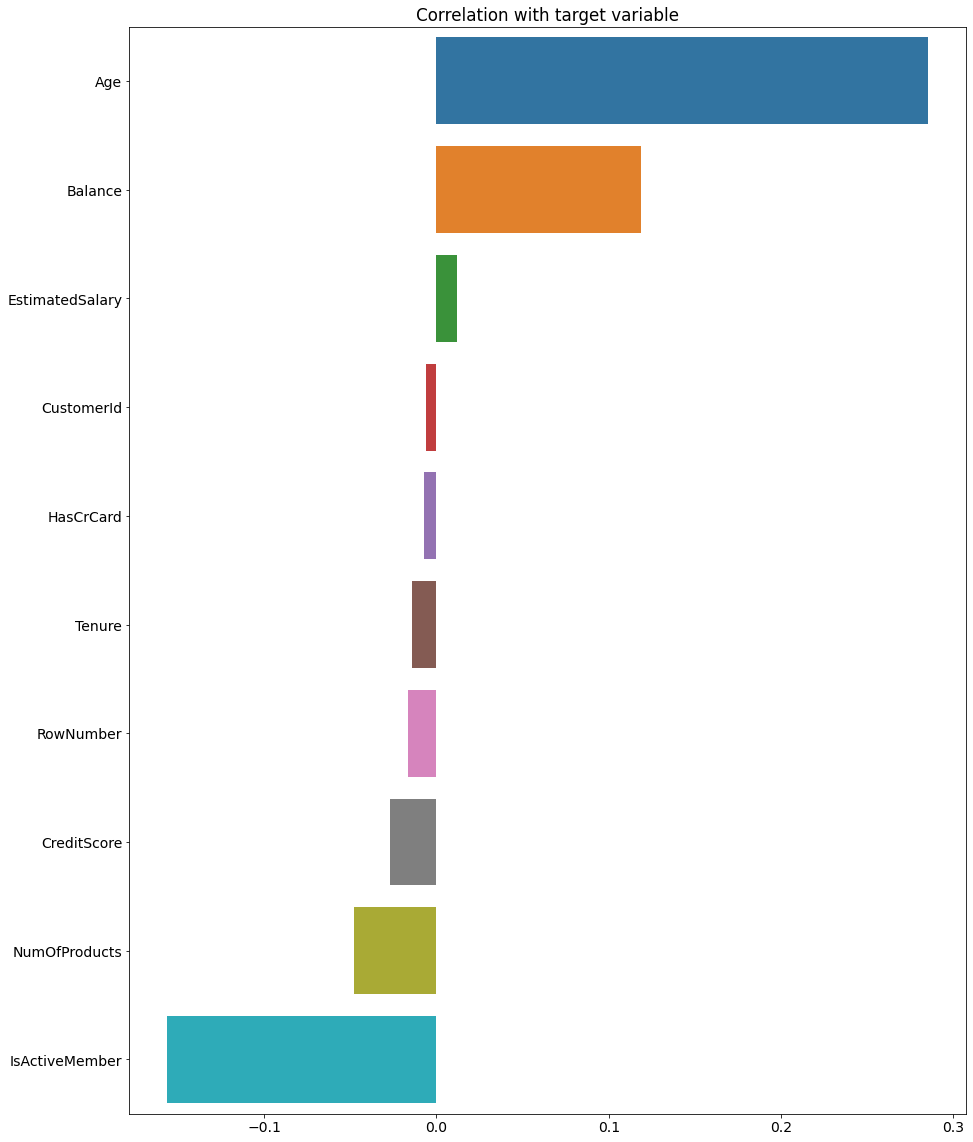

In [14]:
TARGET_NAME = 'Exited'

corr_with_target = df.corr()[TARGET_NAME].sort_values(ascending=False)[1:]
plt.figure(figsize=(15, 20))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

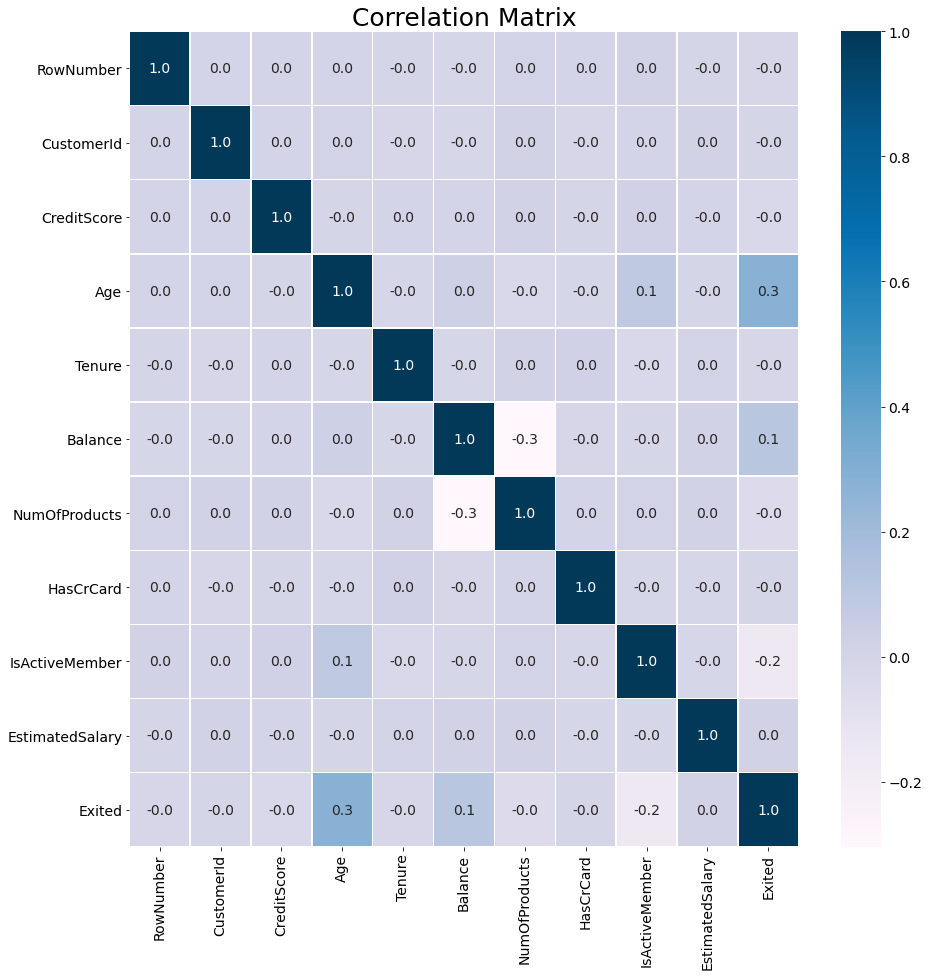

In [15]:
# матрица корреляции
f, ax = plt.subplots(figsize = [15, 15])
sns.heatmap(df.corr(), annot=True, fmt='.1f', linewidths=.5, ax=ax, cmap = 'PuBu' )
ax.set_title('Correlation Matrix', fontsize=25)
plt.show()

In [16]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [17]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [18]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [19]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00000,1,1,1,101348.88000,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86000,1,0,1,112542.58000,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80000,3,1,0,113931.57000,1
3,4,15701354,Boni,699,France,Female,39,1,0.00000,2,0,0,93826.63000,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82000,1,1,1,79084.10000,0


In [20]:
df = df.drop(['CustomerId','Surname'], axis = 1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Exited', 1), df['Exited'], 
                                                    test_size=0.30, 
                                                    random_state=0)

In [22]:
# Балансировка по целевому классу
def balance_df_by_target(train_df, y, portion_of_target_class=0.5, random_state=15):
    counts_0 = (train_df[TARGET_NAME] == 0).sum()
    counts_1 = (train_df[TARGET_NAME] == 1).sum()
    minor_class = 0 if (counts_0 < counts_1) else 1
    if portion_of_target_class > (counts_1 / (counts_1 + counts_0)):
        disbalance = int(counts_0 / (1-portion_of_target_class) - counts_1 - counts_0)
    else:
        disbalance = int(counts_1 / (1-portion_of_target_class) - counts_1 - counts_0)
    sample = train_df[train_df[y] == minor_class].sample(n=disbalance, replace=True, random_state=random_state)

    return pd.concat([sample, train_df], axis=0)

In [24]:
df_balanced = balance_df_by_target(pd.concat([X_train, y_train], axis=1), TARGET_NAME, 0.50, 2)
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [25]:
from imblearn.combine import SMOTETomek

smk = SMOTETomek()
#X_train, y_train = smk.fit_sample(X_train, y_train)
#X_test, y_test = smk.fit_sample(X_test, y_test)

In [26]:
categorical_cols = ['Geography', 'Gender']
continuous_cols = ['CreditScore', 'Tenure', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
base_cols = ['HasCrCard', 'IsActiveMember']

In [27]:
continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuous_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', RobustScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in categorical_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [28]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

feature_processing = Pipeline([('feats', feats)])
df_transform = feature_processing.fit_transform(df)

In [29]:
feats

FeatureUnion(transformer_list=[('CreditScore',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='CreditScore')),
                                                ('standard', RobustScaler())])),
                               ('Tenure',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='Tenure')),
                                                ('standard', RobustScaler())])),
                               ('Age',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='Age')),
                                                ('standard', RobustScaler())])),
                               ('Balance',
                                Pipelin...
                                Pipeline(steps=[('selector',
                                                 ColumnSe

### Первичный подбор моделей

In [30]:
models = []

models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
models.append(('LGBMClassifier', LGBMClassifier()))
models.append(('LogisticRegression', LogisticRegression()))
models.append(('RandomForestClassifier', RandomForestClassifier()))

In [31]:
results = []

for name, model in models:
    pipeline = Pipeline([
    ('features',feats),
    (name, model),
])
    pipeline.fit(X_train, y_train)
    y_pred_train  = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    TRAIN = f1_score(y_train, y_pred_train)
    Accuracy_scores = accuracy_score(y_test, y_pred_test)
    TEST = f1_score(y_test, y_pred_test)
    results.append((name, TRAIN, TEST, Accuracy_scores))
    
best_models = pd.DataFrame(results, columns = ['model', 'TRAIN - f1_score', 'TEST - f1_score', 'Accuracy_scores'])
best_models.sort_values('TEST - f1_score', ascending=False)

,model,TRAIN - f1_score,TEST - f1_score,Accuracy_scores
2,LGBMClassifier,0.91682,0.62869,0.82400
0,CatBoostClassifier,0.92539,0.62651,0.82433
4,RandomForestClassifier,1.00000,0.62045,0.85400
1,GradientBoostingClassifier,0.80765,0.61237,0.79533
3,LogisticRegression,0.70273,0.50533,0.70633


In [32]:
%%time
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier()),
])
pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
print('TRAIN - CatBoostClassifier\n\n' + classification_report(y_train, y_pred_train))
print('TEST - CatBoostClassifier\n\n' + classification_report(y_test, y_pred_test))
print(f'TRAIN - CatBoostClassifier - {f1_score(y_train, y_pred_train)}')
print(f'TEST - CatBoostClassifier - {f1_score(y_test, y_pred_test)}')

Learning rate set to 0.028868
0:	learn: 0.6795646	total: 9.83ms	remaining: 9.82s
1:	learn: 0.6667872	total: 21.4ms	remaining: 10.7s
2:	learn: 0.6531477	total: 31.7ms	remaining: 10.5s
3:	learn: 0.6413905	total: 41ms	remaining: 10.2s
4:	learn: 0.6306541	total: 50.8ms	remaining: 10.1s
5:	learn: 0.6209456	total: 60.8ms	remaining: 10.1s
6:	learn: 0.6117935	total: 70.8ms	remaining: 10s
7:	learn: 0.6020299	total: 80.9ms	remaining: 10s
8:	learn: 0.5932697	total: 90.3ms	remaining: 9.94s
9:	learn: 0.5853012	total: 101ms	remaining: 9.96s
10:	learn: 0.5783339	total: 110ms	remaining: 9.92s
11:	learn: 0.5726396	total: 120ms	remaining: 9.86s
12:	learn: 0.5659703	total: 130ms	remaining: 9.86s
13:	learn: 0.5595906	total: 139ms	remaining: 9.79s
14:	learn: 0.5538738	total: 149ms	remaining: 9.8s
15:	learn: 0.5496452	total: 159ms	remaining: 9.76s
16:	learn: 0.5449007	total: 169ms	remaining: 9.75s
17:	learn: 0.5409551	total: 178ms	remaining: 9.73s
18:	learn: 0.5364419	total: 189ms	remaining: 9.78s
19:	learn

162:	learn: 0.4104591	total: 1.71s	remaining: 8.76s
163:	learn: 0.4099633	total: 1.72s	remaining: 8.75s
164:	learn: 0.4094368	total: 1.73s	remaining: 8.76s
165:	learn: 0.4091510	total: 1.74s	remaining: 8.74s
166:	learn: 0.4089029	total: 1.75s	remaining: 8.72s
167:	learn: 0.4084824	total: 1.76s	remaining: 8.71s
168:	learn: 0.4082526	total: 1.77s	remaining: 8.69s
169:	learn: 0.4080179	total: 1.77s	remaining: 8.67s
170:	learn: 0.4078856	total: 1.78s	remaining: 8.65s
171:	learn: 0.4075193	total: 1.79s	remaining: 8.63s
172:	learn: 0.4072177	total: 1.8s	remaining: 8.62s
173:	learn: 0.4070583	total: 1.81s	remaining: 8.6s
174:	learn: 0.4066902	total: 1.82s	remaining: 8.58s
175:	learn: 0.4064768	total: 1.83s	remaining: 8.57s
176:	learn: 0.4062110	total: 1.84s	remaining: 8.55s
177:	learn: 0.4057786	total: 1.85s	remaining: 8.54s
178:	learn: 0.4053319	total: 1.86s	remaining: 8.52s
179:	learn: 0.4049677	total: 1.87s	remaining: 8.51s
180:	learn: 0.4047685	total: 1.88s	remaining: 8.49s
181:	learn: 0.

334:	learn: 0.3645222	total: 3.4s	remaining: 6.76s
335:	learn: 0.3643347	total: 3.42s	remaining: 6.75s
336:	learn: 0.3641040	total: 3.43s	remaining: 6.74s
337:	learn: 0.3638310	total: 3.44s	remaining: 6.73s
338:	learn: 0.3635171	total: 3.44s	remaining: 6.72s
339:	learn: 0.3632089	total: 3.46s	remaining: 6.71s
340:	learn: 0.3629439	total: 3.46s	remaining: 6.7s
341:	learn: 0.3628228	total: 3.47s	remaining: 6.68s
342:	learn: 0.3625653	total: 3.48s	remaining: 6.67s
343:	learn: 0.3623891	total: 3.49s	remaining: 6.66s
344:	learn: 0.3621909	total: 3.5s	remaining: 6.65s
345:	learn: 0.3619859	total: 3.51s	remaining: 6.64s
346:	learn: 0.3617689	total: 3.52s	remaining: 6.63s
347:	learn: 0.3615451	total: 3.53s	remaining: 6.62s
348:	learn: 0.3612882	total: 3.54s	remaining: 6.6s
349:	learn: 0.3611322	total: 3.55s	remaining: 6.59s
350:	learn: 0.3608708	total: 3.56s	remaining: 6.59s
351:	learn: 0.3606037	total: 3.58s	remaining: 6.58s
352:	learn: 0.3603308	total: 3.59s	remaining: 6.59s
353:	learn: 0.36

496:	learn: 0.3302545	total: 5.13s	remaining: 5.19s
497:	learn: 0.3300873	total: 5.14s	remaining: 5.18s
498:	learn: 0.3297885	total: 5.15s	remaining: 5.17s
499:	learn: 0.3295972	total: 5.16s	remaining: 5.16s
500:	learn: 0.3294191	total: 5.17s	remaining: 5.15s
501:	learn: 0.3291934	total: 5.18s	remaining: 5.14s
502:	learn: 0.3290846	total: 5.19s	remaining: 5.13s
503:	learn: 0.3288824	total: 5.2s	remaining: 5.12s
504:	learn: 0.3287101	total: 5.21s	remaining: 5.11s
505:	learn: 0.3285543	total: 5.22s	remaining: 5.1s
506:	learn: 0.3282739	total: 5.24s	remaining: 5.09s
507:	learn: 0.3281374	total: 5.25s	remaining: 5.08s
508:	learn: 0.3280036	total: 5.26s	remaining: 5.08s
509:	learn: 0.3278718	total: 5.27s	remaining: 5.06s
510:	learn: 0.3277229	total: 5.28s	remaining: 5.05s
511:	learn: 0.3275791	total: 5.29s	remaining: 5.04s
512:	learn: 0.3273603	total: 5.3s	remaining: 5.03s
513:	learn: 0.3272277	total: 5.31s	remaining: 5.02s
514:	learn: 0.3269568	total: 5.32s	remaining: 5.01s
515:	learn: 0.3

670:	learn: 0.2991306	total: 6.88s	remaining: 3.37s
671:	learn: 0.2990228	total: 6.89s	remaining: 3.36s
672:	learn: 0.2987354	total: 6.9s	remaining: 3.35s
673:	learn: 0.2985836	total: 6.91s	remaining: 3.34s
674:	learn: 0.2984465	total: 6.92s	remaining: 3.33s
675:	learn: 0.2983571	total: 6.93s	remaining: 3.32s
676:	learn: 0.2982285	total: 6.94s	remaining: 3.31s
677:	learn: 0.2980498	total: 6.95s	remaining: 3.3s
678:	learn: 0.2979580	total: 6.96s	remaining: 3.29s
679:	learn: 0.2978013	total: 6.96s	remaining: 3.28s
680:	learn: 0.2975765	total: 6.97s	remaining: 3.27s
681:	learn: 0.2975035	total: 6.98s	remaining: 3.25s
682:	learn: 0.2973802	total: 6.99s	remaining: 3.25s
683:	learn: 0.2972320	total: 7s	remaining: 3.23s
684:	learn: 0.2970896	total: 7.01s	remaining: 3.22s
685:	learn: 0.2969372	total: 7.02s	remaining: 3.21s
686:	learn: 0.2967978	total: 7.03s	remaining: 3.2s
687:	learn: 0.2966172	total: 7.04s	remaining: 3.19s
688:	learn: 0.2964161	total: 7.05s	remaining: 3.18s
689:	learn: 0.2961

843:	learn: 0.2700171	total: 8.56s	remaining: 1.58s
844:	learn: 0.2698854	total: 8.57s	remaining: 1.57s
845:	learn: 0.2697394	total: 8.58s	remaining: 1.56s
846:	learn: 0.2696198	total: 8.59s	remaining: 1.55s
847:	learn: 0.2694772	total: 8.6s	remaining: 1.54s
848:	learn: 0.2693831	total: 8.61s	remaining: 1.53s
849:	learn: 0.2692891	total: 8.62s	remaining: 1.52s
850:	learn: 0.2691464	total: 8.63s	remaining: 1.51s
851:	learn: 0.2690763	total: 8.64s	remaining: 1.5s
852:	learn: 0.2688975	total: 8.65s	remaining: 1.49s
853:	learn: 0.2687478	total: 8.66s	remaining: 1.48s
854:	learn: 0.2685876	total: 8.67s	remaining: 1.47s
855:	learn: 0.2684588	total: 8.68s	remaining: 1.46s
856:	learn: 0.2682351	total: 8.69s	remaining: 1.45s
857:	learn: 0.2680947	total: 8.7s	remaining: 1.44s
858:	learn: 0.2679696	total: 8.71s	remaining: 1.43s
859:	learn: 0.2678166	total: 8.71s	remaining: 1.42s
860:	learn: 0.2677322	total: 8.72s	remaining: 1.41s
861:	learn: 0.2676457	total: 8.73s	remaining: 1.4s
862:	learn: 0.26

Confusion matrix, without normalization
[[2031  348]
 [ 179  442]]


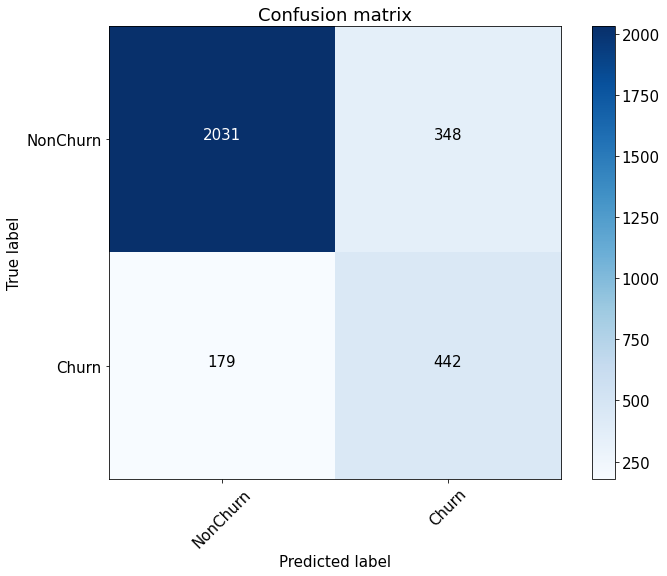

In [33]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [34]:
costs = sum(cnf_matrix[:, 1]) * 1  # Траты
income = cnf_matrix[1, 1] * 2  # Возможный доход
print(f'Возможная прибыть с удержания = {income - costs}$')

Возможная прибыть с удержания = 94$


In [35]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(silent=True)),
])
params = {'classifier__max_depth':[1, 2, 3, 5, 8],
          'classifier__learning_rate':[0.01, 0.02, 0.05]} 
          
grid = GridSearchCV(pipeline, param_grid=params, scoring='f1')
search = grid.fit(X_train, y_train)

print('Best parameters found by grid search are:', search.best_params_)

Best parameters found by grid search are: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 8}


In [36]:
#pipeline.get_params().keys()

In [40]:
%%time
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(learning_rate=0.05, max_depth=8, silent=True, random_state=4)),
])
pipeline.fit(X_train, y_train)
y_pred_train  = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
print('TEST - CatBoostClassifier\n\n' + classification_report(y_test, y_pred_test))
print(f'TRAIN - CatBoostClassifier - {f1_score(y_train, y_pred_train)}')
print(f'TEST - CatBoostClassifier - {f1_score(y_test, y_pred_test)}')

TEST - CatBoostClassifier

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2379
           1       0.62      0.62      0.62       621

    accuracy                           0.84      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.84      0.84      0.84      3000

TRAIN - CatBoostClassifier - 0.9953538241601143
TEST - CatBoostClassifier - 0.6230831315577078
Wall time: 15.8 s


Confusion matrix, without normalization
[[2147  232]
 [ 235  386]]


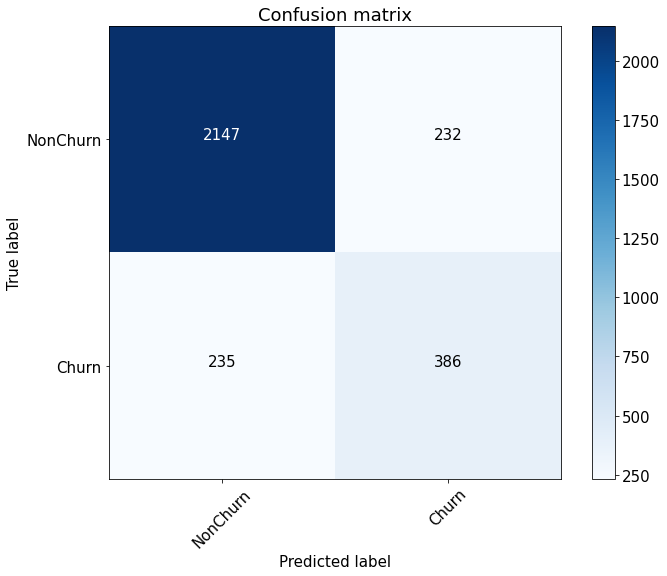

In [41]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [42]:
costs = sum(cnf_matrix[:, 1]) * 1  # Траты
income = cnf_matrix[1, 1] * 2  # Возможный доход
print(f'Возможная прибыть с удержания = {income - costs}$')

Возможная прибыть с удержания = 154$


Вывод: проведенная оценка экономической эффективности после подбора гиперпараметров модели показала, что есть эффект от проделанной работы по улучшению модели.
P.S. Все возможные варианты добавления новых признаков дадут значительный прирост в качестве, а также другие виды обработки данных. Лично у меня не получилось встроить в пайплайн операцию по балансировке данных с помощью библиотеки SMOTETomek. Есть ли возможность реализовать это? 